In [2]:
import numpy as np
from scipy.optimize import minimize
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter


from leverage_scores import compute_leverage

from row_sampling import leverage_sampling, l2s_sampling, uniform_sampling

# **Data cleaning and pre-processing**

In [3]:
df = pd.read_csv('Bank Customer Churn Prediction.csv')
df = df.drop('customer_id', axis=1)
df = pd.get_dummies(df, columns=['gender'], prefix='gender', drop_first=True)
df = pd.get_dummies(df, columns=['country'], prefix='country', drop_first=True)
df.info()

X_raw = df.drop('churn', axis=1).values
y = df['churn'].values

scaler = StandardScaler()
X = scaler.fit_transform(X_raw)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   age               10000 non-null  int64  
 2   tenure            10000 non-null  int64  
 3   balance           10000 non-null  float64
 4   products_number   10000 non-null  int64  
 5   credit_card       10000 non-null  int64  
 6   active_member     10000 non-null  int64  
 7   estimated_salary  10000 non-null  float64
 8   churn             10000 non-null  int64  
 9   gender_Male       10000 non-null  uint8  
 10  country_Germany   10000 non-null  uint8  
 11  country_Spain     10000 non-null  uint8  
dtypes: float64(2), int64(7), uint8(3)
memory usage: 732.5 KB


# **Define the necessary functions for gradient, NLL etc.**

In [16]:

# Logistic function (sigmoid)
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Negative log likelihood
def neg_log_likelihood(theta, X, y):
    z = np.dot(X, theta)
    return -np.sum(y * z - np.logaddexp(0, z))

def lev_neg_log_likelihood(theta, X, y):
    z = np.dot(X, theta)
    log_sum_exp = np.logaddexp(0, z)
    return -np.sum(w*y[ind] * z[ind] - w*log_sum_exp[ind])

def l2s_neg_log_likelihood(theta, X, y):
    z = np.dot(X, theta)
    return -np.sum(w_l2s * y[ind_l2s] * z[ind_l2s] - w_l2s * np.logaddexp(0, z)[ind_l2s])

def unif_neg_log_likelihood(theta, X, y):
    z = np.dot(X, theta)
    log_sum_exp = np.logaddexp(0, z)
    return -np.sum(y[ind_unif] * z[ind_unif] - log_sum_exp[ind_unif])



# Gradient of negative log likelihood
def gradient(theta, X, y):
    z = np.dot(X, theta)
    return np.dot(X.T, sigmoid(z) - y)

def lev_gradient(theta, X, y):
    z = np.dot(X, theta)
    return np.dot(X.T[:,ind], np.dot(np.diag(w),(sigmoid(z) - y)[ind]))

def l2s_gradient(theta, X, y):
    z = np.dot(X, theta)
    return np.dot(X.T[:,ind_l2s], np.dot(np.diag(w_l2s),(sigmoid(z) - y)[ind_l2s]))

def unif_gradient(theta, X, y):
    z = np.dot(X, theta)
    return np.dot(X.T[:,ind_unif], (sigmoid(z) - y)[ind_unif])

# **Run the full-data model**

In [17]:
initial_theta = np.zeros(X.shape[1])

result_opt = minimize(neg_log_likelihood, initial_theta, args=(X, y), 
                              method='BFGS', jac=gradient)

est_probs_opt = (sigmoid(np.dot(X, result_opt.x)))
opt_pred_labels = (est_probs_opt > 0.5).astype(int)
opt_misclassification_rate = np.mean(opt_pred_labels != y)
print(f"Full data misclassification rate: {opt_misclassification_rate: .6f}")

Full data misclassification rate:  0.352700


# **Run the sampling algorithms for varying sample sizes**

In [18]:
s_values = range(100,5000,100)

# Number of times to run the analysis for each s value
num_runs = 20

# Initialize lists to store mean relative errors
mean_rel_est_probs_lev_list = []
mean_rel_est_probs_l2s_list = []
mean_rel_est_probs_unif_list = []

mean_lev_misclassification_rate_list = []
mean_l2s_misclassification_rate_list = []
mean_unif_misclassification_rate_list = []

mean_rel_lev_neg_log_likelihood_list = []
mean_rel_l2s_neg_log_likelihood_list = []
mean_rel_unif_neg_log_likelihood_list = []

mean_rel_lev_true_neg_log_likelihood_list = []
mean_rel_l2s_true_neg_log_likelihood_list = []
mean_rel_unif_true_neg_log_likelihood_list = []


# Initialize lists for standard deviations

std_rel_est_probs_lev_list = []
std_rel_est_probs_l2s_list = []
std_rel_est_probs_unif_list = []

std_lev_misclassification_rate_list = []
std_l2s_misclassification_rate_list = []
std_unif_misclassification_rate_list = []

std_rel_lev_neg_log_likelihood_list = []
std_rel_l2s_neg_log_likelihood_list = []
std_rel_unif_neg_log_likelihood_list = []

std_rel_lev_true_neg_log_likelihood_list = []
std_rel_l2s_true_neg_log_likelihood_list = []
std_rel_unif_true_neg_log_likelihood_list = []



for s in s_values:
    
    rel_est_probs_lev_list = []
    rel_est_probs_l2s_list = []
    rel_est_probs_unif_list = []
    
    lev_misclassification_rate_list = []
    l2s_misclassification_rate_list = []
    unif_misclassification_rate_list = []
    
    rel_lev_neg_log_likelihood_list = []
    rel_l2s_neg_log_likelihood_list = []
    rel_unif_neg_log_likelihood_list = []
    
    rel_lev_true_neg_log_likelihood_list = []
    rel_l2s_true_neg_log_likelihood_list = []
    rel_unif_true_neg_log_likelihood_list = []

    for run in range(num_runs):
        
        
        # Pick the indices and weights for leverage, l2s, and uniform sampling
        ind, w = leverage_sampling (data=X, size=s)

        ind_l2s, w_l2s = l2s_sampling(data=X, size=s, k=20)

        ind_unif = uniform_sampling(data=X, size=s)
        
        

        # Calculate parameters using leverage, l2s, and uniform methods
        result_lev = minimize(lev_neg_log_likelihood, initial_theta, args=(X, y), 
                              method='BFGS', jac=lev_gradient)
        
        result_l2s = minimize(l2s_neg_log_likelihood, initial_theta, args=(X, y), 
                              method='BFGS', jac=l2s_gradient)

        result_unif = minimize(unif_neg_log_likelihood, initial_theta, args=(X, y), 
                              method='BFGS', jac=unif_gradient)

        
        # Calculate estimated probabilities and predicted labels
        est_probs_lev = (sigmoid(np.dot(X, result_lev.x)))
        est_probs_l2s = (sigmoid(np.dot(X, result_l2s.x)))
        est_probs_unif = (sigmoid(np.dot(X, result_unif.x)))

        lev_pred_labels = (est_probs_lev > 0.5).astype(int)
        l2s_pred_labels = (est_probs_l2s > 0.5).astype(int)
        unif_pred_labels = (est_probs_unif > 0.5).astype(int)

        # Calculate misclassification rates and relative errors
        
        rel_est_probs_lev = np.linalg.norm(est_probs_lev - est_probs_opt) / np.linalg.norm(est_probs_opt)
        rel_est_probs_l2s = np.linalg.norm(est_probs_l2s - est_probs_opt) / np.linalg.norm(est_probs_opt)
        rel_est_probs_unif = np.linalg.norm(est_probs_unif - est_probs_opt) / np.linalg.norm(est_probs_opt)
        
        lev_misclassification_rate = np.mean(lev_pred_labels != y)
        l2s_misclassification_rate = np.mean(l2s_pred_labels != y)
        unif_misclassification_rate = np.mean(unif_pred_labels != y)
        
        rel_lev_neg_log_likelihood= np.abs(neg_log_likelihood(result_opt.x,X,y)-lev_neg_log_likelihood(result_lev.x,X,y))/neg_log_likelihood(result_opt.x,X,y)
        rel_l2s_neg_log_likelihood= np.abs(neg_log_likelihood(result_opt.x,X,y)-l2s_neg_log_likelihood(result_l2s.x,X,y))/neg_log_likelihood(result_opt.x,X,y)                    
        rel_unif_neg_log_likelihood= np.abs(neg_log_likelihood(result_opt.x,X,y)-unif_neg_log_likelihood(result_unif.x,X,y))/neg_log_likelihood(result_opt.x,X,y)

        rel_lev_true_neg_log_likelihood= np.abs(neg_log_likelihood(result_opt.x,X,y)-neg_log_likelihood(result_lev.x,X,y))/neg_log_likelihood(result_opt.x,X,y)
        rel_l2s_true_neg_log_likelihood= np.abs(neg_log_likelihood(result_opt.x,X,y)-neg_log_likelihood(result_l2s.x,X,y))/neg_log_likelihood(result_opt.x,X,y)                    
        rel_unif_true_neg_log_likelihood= np.abs(neg_log_likelihood(result_opt.x,X,y)-neg_log_likelihood(result_unif.x,X,y))/neg_log_likelihood(result_opt.x,X,y)

        
        # Append to lists
        
        rel_est_probs_lev_list.append(rel_est_probs_lev)
        rel_est_probs_l2s_list.append(rel_est_probs_l2s)
        rel_est_probs_unif_list.append(rel_est_probs_unif)
        
        lev_misclassification_rate_list.append(lev_misclassification_rate)
        l2s_misclassification_rate_list.append(l2s_misclassification_rate)
        unif_misclassification_rate_list.append(unif_misclassification_rate)
        
        rel_lev_neg_log_likelihood_list.append(rel_lev_neg_log_likelihood)
        rel_l2s_neg_log_likelihood_list.append(rel_l2s_neg_log_likelihood)
        rel_unif_neg_log_likelihood_list.append(rel_unif_neg_log_likelihood)
        
        rel_lev_true_neg_log_likelihood_list.append(rel_lev_true_neg_log_likelihood)
        rel_l2s_true_neg_log_likelihood_list.append(rel_l2s_true_neg_log_likelihood)
        rel_unif_true_neg_log_likelihood_list.append(rel_unif_true_neg_log_likelihood)      


    # Calculate mean relative errors for each s value
    
    mean_rel_est_probs_lev = np.mean(rel_est_probs_lev_list)
    mean_rel_est_probs_l2s = np.mean(rel_est_probs_l2s_list)
    mean_rel_est_probs_unif = np.mean(rel_est_probs_unif_list)
                              
    mean_lev_misclassification_rate = np.mean(lev_misclassification_rate_list)
    mean_l2s_misclassification_rate = np.mean(l2s_misclassification_rate_list)                          
    mean_unif_misclassification_rate = np.mean(unif_misclassification_rate_list)
    
    mean_rel_lev_neg_log_likelihood = np.mean(rel_lev_neg_log_likelihood_list)
    mean_rel_l2s_neg_log_likelihood = np.mean(rel_l2s_neg_log_likelihood_list)
    mean_rel_unif_neg_log_likelihood = np.mean(rel_unif_neg_log_likelihood_list)
    
    mean_rel_lev_true_neg_log_likelihood = np.mean(rel_lev_true_neg_log_likelihood_list)
    mean_rel_l2s_true_neg_log_likelihood = np.mean(rel_l2s_true_neg_log_likelihood_list)
    mean_rel_unif_true_neg_log_likelihood = np.mean(rel_unif_true_neg_log_likelihood_list)
    
    # Calculate standard deviations of errors for each s value
    
    std_rel_est_probs_lev = np.std(rel_est_probs_lev_list)
    std_rel_est_probs_l2s = np.std(rel_est_probs_l2s_list)
    std_rel_est_probs_unif = np.std(rel_est_probs_unif_list)
                              
    std_lev_misclassification_rate = np.std(lev_misclassification_rate_list)
    std_l2s_misclassification_rate = np.std(l2s_misclassification_rate_list)                          
    std_unif_misclassification_rate = np.std(unif_misclassification_rate_list)
    
    std_rel_lev_neg_log_likelihood = np.std(rel_lev_neg_log_likelihood_list)
    std_rel_l2s_neg_log_likelihood = np.std(rel_l2s_neg_log_likelihood_list)
    std_rel_unif_neg_log_likelihood = np.std(rel_unif_neg_log_likelihood_list)
    
    std_rel_lev_true_neg_log_likelihood = np.std(rel_lev_true_neg_log_likelihood_list)
    std_rel_l2s_true_neg_log_likelihood = np.std(rel_l2s_true_neg_log_likelihood_list)
    std_rel_unif_true_neg_log_likelihood = np.std(rel_unif_true_neg_log_likelihood_list)
    
    
    # Append mean values to the lists
    
    mean_rel_est_probs_lev_list.append(mean_rel_est_probs_lev)
    mean_rel_est_probs_l2s_list.append(mean_rel_est_probs_l2s)
    mean_rel_est_probs_unif_list.append(mean_rel_est_probs_unif)
                              
    mean_lev_misclassification_rate_list.append(mean_lev_misclassification_rate)
    mean_l2s_misclassification_rate_list.append(mean_l2s_misclassification_rate)
    mean_unif_misclassification_rate_list.append(mean_unif_misclassification_rate)
    
    mean_rel_lev_neg_log_likelihood_list.append(mean_rel_lev_neg_log_likelihood)
    mean_rel_l2s_neg_log_likelihood_list.append(mean_rel_l2s_neg_log_likelihood)
    mean_rel_unif_neg_log_likelihood_list.append(mean_rel_unif_neg_log_likelihood)
    
    mean_rel_lev_true_neg_log_likelihood_list.append(mean_rel_lev_true_neg_log_likelihood)
    mean_rel_l2s_true_neg_log_likelihood_list.append(mean_rel_l2s_true_neg_log_likelihood)
    mean_rel_unif_true_neg_log_likelihood_list.append(mean_rel_unif_true_neg_log_likelihood)
    
    # Append standard deviation values to the lists
    
    std_rel_est_probs_lev_list.append(std_rel_est_probs_lev)
    std_rel_est_probs_l2s_list.append(std_rel_est_probs_l2s)
    std_rel_est_probs_unif_list.append(std_rel_est_probs_unif)
                              
    std_lev_misclassification_rate_list.append(std_lev_misclassification_rate)
    std_l2s_misclassification_rate_list.append(std_l2s_misclassification_rate)
    std_unif_misclassification_rate_list.append(std_unif_misclassification_rate)
    
    std_rel_lev_neg_log_likelihood_list.append(std_rel_lev_neg_log_likelihood)
    std_rel_l2s_neg_log_likelihood_list.append(std_rel_l2s_neg_log_likelihood)
    std_rel_unif_neg_log_likelihood_list.append(std_rel_unif_neg_log_likelihood)
    
    std_rel_lev_true_neg_log_likelihood_list.append(std_rel_lev_true_neg_log_likelihood)
    std_rel_l2s_true_neg_log_likelihood_list.append(std_rel_l2s_true_neg_log_likelihood)
    std_rel_unif_true_neg_log_likelihood_list.append(std_rel_unif_true_neg_log_likelihood)
                              

    # Print the mean relative errors for each s
                             
    print(f"Mean Relative Error Estimated Probs Leverage for s = {s}: {mean_rel_est_probs_lev}")
    print(f"Mean Relative Error Estimated Probs L2S for s = {s}: {mean_rel_est_probs_l2s}")
    print(f"Mean Relative Error Estimated Probs Uniform for s = {s}: {mean_rel_est_probs_unif}")
    print("-----------------------------------------------------------------------")                          
    print(f"Mean Leverage Misclassification Rate for s = {s}: {mean_lev_misclassification_rate}")
    print(f"Mean L2S Misclassification Rate for s = {s}: {mean_l2s_misclassification_rate}")
    print(f"Mean Uniform Misclassification Rate for s = {s}: {mean_unif_misclassification_rate}")
    print("-----------------------------------------------------------------------") 
    print(f"Mean Relative Error Leverage Negative Log Likelihood for s = {s}: {mean_rel_lev_neg_log_likelihood}")
    print(f"Mean Relative Error L2S Negative Log Likelihood for s = {s}: {mean_rel_l2s_neg_log_likelihood}")
    print(f"Mean Relative Error Uniform Negative Log Likelihood for s = {s}: {mean_rel_unif_neg_log_likelihood}")
    print("-----------------------------------------------------------------------") 
    print(f"Mean Relative Error Leverage True Negative Log Likelihood for s = {s}: {mean_rel_lev_true_neg_log_likelihood}")
    print(f"Mean Relative Error L2S Negative True Log Likelihood for s = {s}: {mean_rel_l2s_true_neg_log_likelihood}")
    print(f"Mean Relative Error Uniform True Negative Log Likelihood for s = {s}: {mean_rel_unif_true_neg_log_likelihood}")
    print("=" * 60)
    


# Convert lists to arrays    

# mean
mean_rel_est_probs_lev_array = np.array(mean_rel_est_probs_lev_list)
mean_rel_est_probs_l2s_array = np.array(mean_rel_est_probs_l2s_list)
mean_rel_est_probs_unif_array = np.array(mean_rel_est_probs_unif_list)
                              
mean_lev_misclassification_rate_array = np.array(mean_lev_misclassification_rate_list)
mean_l2s_misclassification_rate_array = np.array(mean_l2s_misclassification_rate_list)
mean_unif_misclassification_rate_array = np.array(mean_unif_misclassification_rate_list)

mean_rel_lev_neg_log_likelihood_array = np.array(mean_rel_lev_neg_log_likelihood_list)
mean_rel_l2s_neg_log_likelihood_array = np.array(mean_rel_l2s_neg_log_likelihood_list)
mean_rel_unif_neg_log_likelihood_array = np.array(mean_rel_unif_neg_log_likelihood_list)

mean_rel_lev_true_neg_log_likelihood_array = np.array(mean_rel_lev_true_neg_log_likelihood_list)
mean_rel_l2s_true_neg_log_likelihood_array = np.array(mean_rel_l2s_true_neg_log_likelihood_list)
mean_rel_unif_true_neg_log_likelihood_array = np.array(mean_rel_unif_true_neg_log_likelihood_list)

# stdev
std_rel_est_probs_lev_array = np.array(std_rel_est_probs_lev_list)
std_rel_est_probs_l2s_array = np.array(std_rel_est_probs_l2s_list)
std_rel_est_probs_unif_array = np.array(std_rel_est_probs_unif_list)
                              
std_lev_misclassification_rate_array = np.array(std_lev_misclassification_rate_list)
std_l2s_misclassification_rate_array = np.array(std_l2s_misclassification_rate_list)
std_unif_misclassification_rate_array = np.array(std_unif_misclassification_rate_list)

std_rel_lev_neg_log_likelihood_array = np.array(std_rel_lev_neg_log_likelihood_list)
std_rel_l2s_neg_log_likelihood_array = np.array(std_rel_l2s_neg_log_likelihood_list)
std_rel_unif_neg_log_likelihood_array = np.array(std_rel_unif_neg_log_likelihood_list)

std_rel_lev_true_neg_log_likelihood_array = np.array(std_rel_lev_true_neg_log_likelihood_list)
std_rel_l2s_true_neg_log_likelihood_array = np.array(std_rel_l2s_true_neg_log_likelihood_list)
std_rel_unif_true_neg_log_likelihood_array = np.array(std_rel_unif_true_neg_log_likelihood_list)



Mean Relative Error Estimated Probs Leverage for s = 100: 0.3069448853049243
Mean Relative Error Estimated Probs L2S for s = 100: 0.3319680182847709
Mean Relative Error Estimated Probs Uniform for s = 100: 0.28433211312028217
-----------------------------------------------------------------------
Mean Leverage Misclassification Rate for s = 100: 0.399965
Mean L2S Misclassification Rate for s = 100: 0.39429499999999995
Mean Uniform Misclassification Rate for s = 100: 0.38952000000000003
-----------------------------------------------------------------------
Mean Relative Error Leverage Negative Log Likelihood for s = 100: 0.08855001764869455
Mean Relative Error L2S Negative Log Likelihood for s = 100: 0.10408381053057061
Mean Relative Error Uniform Negative Log Likelihood for s = 100: 0.9908829151005349
-----------------------------------------------------------------------
Mean Relative Error Leverage True Negative Log Likelihood for s = 100: 0.11050036338155618
Mean Relative Error L2S

Mean Relative Error Estimated Probs Leverage for s = 800: 0.09982872340528207
Mean Relative Error Estimated Probs L2S for s = 800: 0.0987928278542413
Mean Relative Error Estimated Probs Uniform for s = 800: 0.10763924928125104
-----------------------------------------------------------------------
Mean Leverage Misclassification Rate for s = 800: 0.36251
Mean L2S Misclassification Rate for s = 800: 0.36070499999999994
Mean Uniform Misclassification Rate for s = 800: 0.365225
-----------------------------------------------------------------------
Mean Relative Error Leverage Negative Log Likelihood for s = 800: 0.019653800230773674
Mean Relative Error L2S Negative Log Likelihood for s = 800: 0.01907677715456243
Mean Relative Error Uniform Negative Log Likelihood for s = 800: 0.9241763868913834
-----------------------------------------------------------------------
Mean Relative Error Leverage True Negative Log Likelihood for s = 800: 0.01003584752034246
Mean Relative Error L2S Negative 

Mean Relative Error Estimated Probs Leverage for s = 1500: 0.07718409731934532
Mean Relative Error Estimated Probs L2S for s = 1500: 0.06685202801845512
Mean Relative Error Estimated Probs Uniform for s = 1500: 0.0714201266920916
-----------------------------------------------------------------------
Mean Leverage Misclassification Rate for s = 1500: 0.36117999999999995
Mean L2S Misclassification Rate for s = 1500: 0.354305
Mean Uniform Misclassification Rate for s = 1500: 0.361415
-----------------------------------------------------------------------
Mean Relative Error Leverage Negative Log Likelihood for s = 1500: 0.009823833798838869
Mean Relative Error L2S Negative Log Likelihood for s = 1500: 0.011896877621130703
Mean Relative Error Uniform Negative Log Likelihood for s = 1500: 0.8607671555390624
-----------------------------------------------------------------------
Mean Relative Error Leverage True Negative Log Likelihood for s = 1500: 0.005911217782740925
Mean Relative Error 

Mean Relative Error Estimated Probs Leverage for s = 2200: 0.06248578697977394
Mean Relative Error Estimated Probs L2S for s = 2200: 0.05699085422106874
Mean Relative Error Estimated Probs Uniform for s = 2200: 0.060461851428250515
-----------------------------------------------------------------------
Mean Leverage Misclassification Rate for s = 2200: 0.36008
Mean L2S Misclassification Rate for s = 2200: 0.35597500000000004
Mean Uniform Misclassification Rate for s = 2200: 0.35775499999999993
-----------------------------------------------------------------------
Mean Relative Error Leverage Negative Log Likelihood for s = 2200: 0.008763418901029937
Mean Relative Error L2S Negative Log Likelihood for s = 2200: 0.008751755484369123
Mean Relative Error Uniform Negative Log Likelihood for s = 2200: 0.8028761382437262
-----------------------------------------------------------------------
Mean Relative Error Leverage True Negative Log Likelihood for s = 2200: 0.003979509802805952
Mean Rel

Mean Relative Error Estimated Probs Leverage for s = 2900: 0.05470887894420097
Mean Relative Error Estimated Probs L2S for s = 2900: 0.048849033545647895
Mean Relative Error Estimated Probs Uniform for s = 2900: 0.05250805984333644
-----------------------------------------------------------------------
Mean Leverage Misclassification Rate for s = 2900: 0.356755
Mean L2S Misclassification Rate for s = 2900: 0.355345
Mean Uniform Misclassification Rate for s = 2900: 0.356395
-----------------------------------------------------------------------
Mean Relative Error Leverage Negative Log Likelihood for s = 2900: 0.006048228632740255
Mean Relative Error L2S Negative Log Likelihood for s = 2900: 0.006999626373653654
Mean Relative Error Uniform Negative Log Likelihood for s = 2900: 0.7479511052299763
-----------------------------------------------------------------------
Mean Relative Error Leverage True Negative Log Likelihood for s = 2900: 0.0029217296086714575
Mean Relative Error L2S Nega

Mean Relative Error Estimated Probs Leverage for s = 3600: 0.049359842614476124
Mean Relative Error Estimated Probs L2S for s = 3600: 0.04221706261265699
Mean Relative Error Estimated Probs Uniform for s = 3600: 0.042975513515541824
-----------------------------------------------------------------------
Mean Leverage Misclassification Rate for s = 3600: 0.35656499999999997
Mean L2S Misclassification Rate for s = 3600: 0.35483000000000003
Mean Uniform Misclassification Rate for s = 3600: 0.35647
-----------------------------------------------------------------------
Mean Relative Error Leverage Negative Log Likelihood for s = 3600: 0.0074084953847338
Mean Relative Error L2S Negative Log Likelihood for s = 3600: 0.008511683266534831
Mean Relative Error Uniform Negative Log Likelihood for s = 3600: 0.6982229527247417
-----------------------------------------------------------------------
Mean Relative Error Leverage True Negative Log Likelihood for s = 3600: 0.0023678565099866625
Mean Rel

Mean Relative Error Estimated Probs Leverage for s = 4300: 0.04556830083712779
Mean Relative Error Estimated Probs L2S for s = 4300: 0.03741198778303025
Mean Relative Error Estimated Probs Uniform for s = 4300: 0.04387963934723348
-----------------------------------------------------------------------
Mean Leverage Misclassification Rate for s = 4300: 0.35668
Mean L2S Misclassification Rate for s = 4300: 0.35326
Mean Uniform Misclassification Rate for s = 4300: 0.35529
-----------------------------------------------------------------------
Mean Relative Error Leverage Negative Log Likelihood for s = 4300: 0.006668159332936287
Mean Relative Error L2S Negative Log Likelihood for s = 4300: 0.008758880301826845
Mean Relative Error Uniform Negative Log Likelihood for s = 4300: 0.6524096881811927
-----------------------------------------------------------------------
Mean Relative Error Leverage True Negative Log Likelihood for s = 4300: 0.002022586141794556
Mean Relative Error L2S Negative 

# **Plot relative error estimated probabilities for the various sampling**

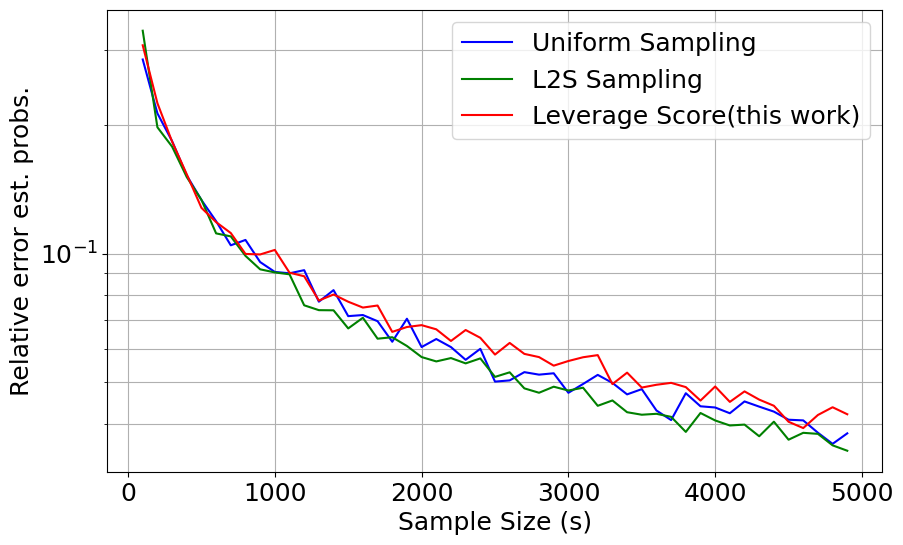

In [45]:
# Smooth the curves using a rolling average with window size
window_size =1

smoothed_lev_prob = np.convolve(mean_rel_est_probs_lev_array, np.ones(window_size)/window_size, mode='valid')
smoothed_l2s_prob = np.convolve(mean_rel_est_probs_l2s_array, np.ones(window_size)/window_size, mode='valid')
smoothed_unif_prob = np.convolve(mean_rel_est_probs_unif_array, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(10, 6))

plt.plot(s_values[window_size-1:], smoothed_unif_prob, label="Uniform Sampling", color='b')
plt.plot(s_values[window_size-1:], smoothed_l2s_prob, label="L2S Sampling", color='g')
plt.plot(s_values[window_size-1:], smoothed_lev_prob, label="Leverage Score(this work)", color='r')

plt.xlabel("Sample Size (s)", fontsize=18)
plt.ylabel("Relative error est. probs.",fontsize=18)
plt.legend(fontsize=18)
plt.grid(True, which='both')
plt.yscale('log')  # Set y-axis to log scale
# plt.xscale('log')

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('plots\\prob_churn.png', dpi=300)
plt.show()

# **Plot misclassification rates for the various sampling methods**

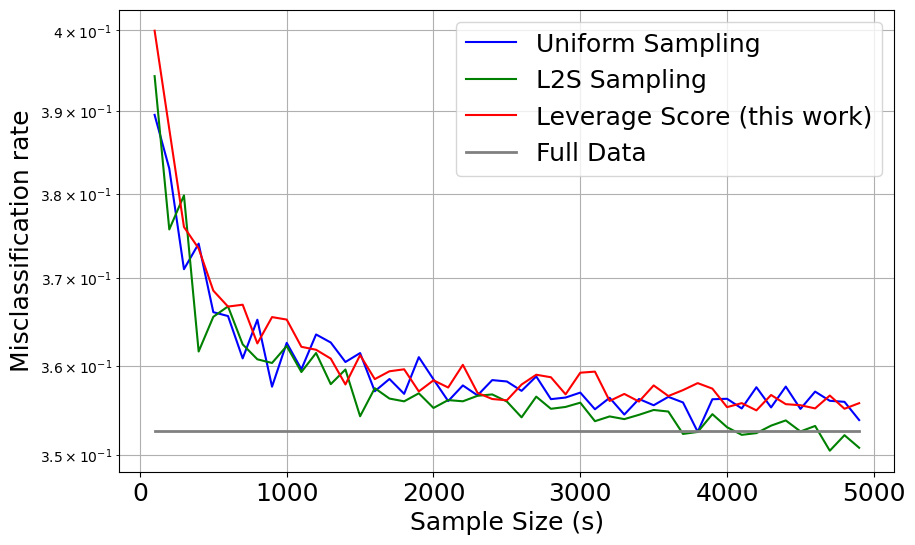

In [46]:
# Smooth the curves using a rolling average with window size
window_size =1

smoothed_lev_mis = np.convolve(mean_lev_misclassification_rate_array, np.ones(window_size)/window_size, mode='valid')
smoothed_l2s_mis = np.convolve(mean_l2s_misclassification_rate_array, np.ones(window_size)/window_size, mode='valid')
smoothed_unif_mis = np.convolve(mean_unif_misclassification_rate_array, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(10, 6))

optimal_misclassification_rate = np.full(len(s_values[window_size-1:]), opt_misclassification_rate)



plt.plot(s_values[window_size-1:], smoothed_unif_mis, label="Uniform Sampling", color='b')
plt.plot(s_values[window_size-1:], smoothed_l2s_mis, label="L2S Sampling", color='g')
plt.plot(s_values[window_size-1:], smoothed_lev_mis, label="Leverage Score (this work)", color='r')

plt.plot(s_values[window_size-1:], optimal_misclassification_rate, label="Full Data", color='gray', linestyle='-',linewidth=2)


plt.xlabel("Sample Size (s)", fontsize=18)
plt.ylabel("Misclassification rate",fontsize=18)
plt.legend(fontsize=18, loc='upper right', bbox_to_anchor=(1, 1))
plt.grid(True, which='both')
plt.yscale('log')  # Set y-axis to log scale
# plt.xscale('log')

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('plots\\mis_churn.png', dpi=300)
plt.show()

# **Plot relative error subsampled NLL for the various sampling methods**

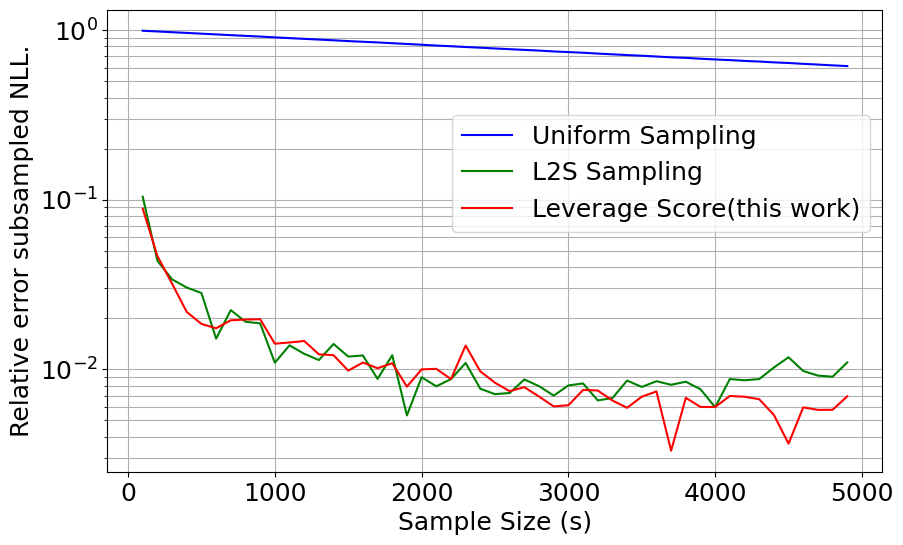

In [47]:
# Smooth the curves using a rolling average with window size 5
window_size =1

smoothed_lev_NLL = np.convolve(mean_rel_lev_neg_log_likelihood_array, np.ones(window_size)/window_size, mode='valid')
smoothed_l2s_NLL = np.convolve(mean_rel_l2s_neg_log_likelihood_array, np.ones(window_size)/window_size, mode='valid')
smoothed_unif_NLL = np.convolve(mean_rel_unif_neg_log_likelihood_array, np.ones(window_size)/window_size, mode='valid')

# Plot the mean values for misclassification rates with smoothed curves
plt.figure(figsize=(10, 6))


plt.plot(s_values[window_size-1:], smoothed_unif_NLL, label="Uniform Sampling", color='b')
plt.plot(s_values[window_size-1:], smoothed_l2s_NLL, label="L2S Sampling", color='g')
plt.plot(s_values[window_size-1:], smoothed_lev_NLL, label="Leverage Score(this work)", color='r')

plt.xlabel("Sample Size (s)", fontsize=18)
plt.ylabel("Relative error subsampled NLL.",fontsize=18)
plt.legend(fontsize=18)
plt.grid(True, which='both')
plt.legend(fontsize=18, loc='upper right', bbox_to_anchor=(1, 0.8))
plt.yscale('log')  # Set y-axis to log scale
# plt.xscale('log')

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('plots\\subsampled_NLL_churn.png', dpi=300)
plt.show()

# **Plot relative error full-data NLL for the various sampling methods**

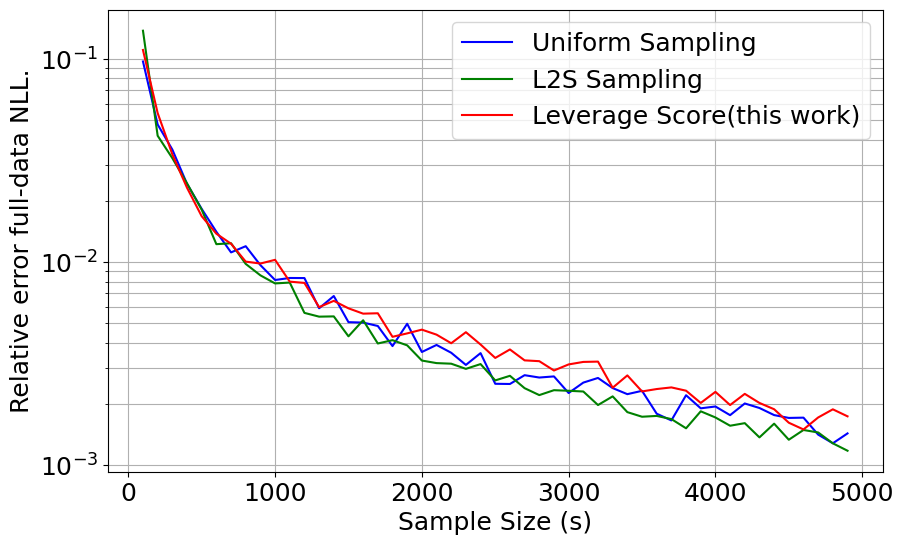

In [48]:
# Smooth the curves using a rolling average with window size 5
window_size =1

smoothed_lev_true_NLL = np.convolve(mean_rel_lev_true_neg_log_likelihood_array, np.ones(window_size)/window_size, mode='valid')
smoothed_l2s_true_NLL = np.convolve(mean_rel_l2s_true_neg_log_likelihood_array, np.ones(window_size)/window_size, mode='valid')
smoothed_unif_true_NLL = np.convolve(mean_rel_unif_true_neg_log_likelihood_array, np.ones(window_size)/window_size, mode='valid')

# Plot the mean values for misclassification rates with smoothed curves
plt.figure(figsize=(10, 6))


plt.plot(s_values[window_size-1:], smoothed_unif_true_NLL, label="Uniform Sampling", color='b')
plt.plot(s_values[window_size-1:], smoothed_l2s_true_NLL, label="L2S Sampling", color='g')
plt.plot(s_values[window_size-1:], smoothed_lev_true_NLL, label="Leverage Score(this work)", color='r')

plt.xlabel("Sample Size (s)", fontsize=18)
plt.ylabel("Relative error full-data NLL.",fontsize=18)
plt.legend(fontsize=18)
plt.grid(True, which='both')
plt.legend(fontsize=18, loc='upper right', bbox_to_anchor=(1, 1))
plt.yscale('log')  # Set y-axis to log scale
# plt.xscale('log')

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('plots\\fulldata_NLL_churn.png', dpi=300)
plt.show()

# **Plot the standard deviations**

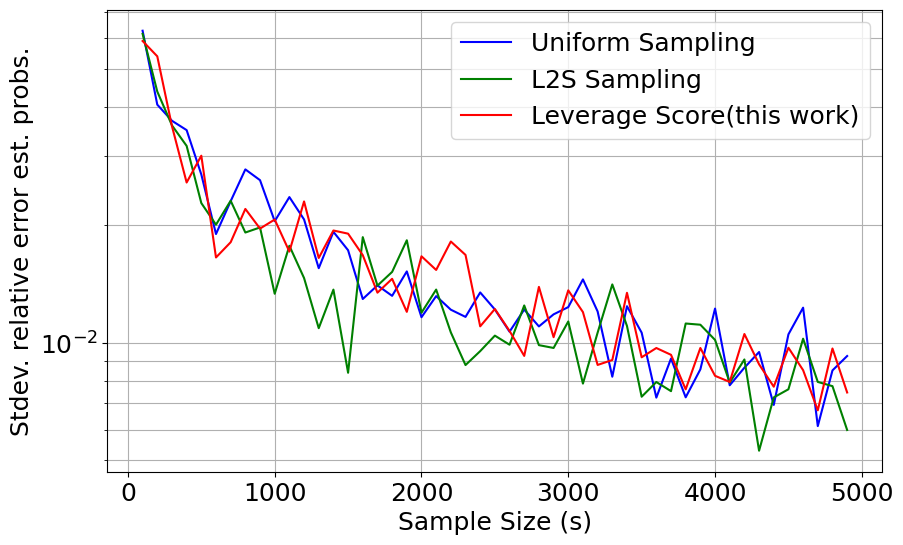

In [49]:
# Smooth the curves using a rolling average with window size
window_size =1

smoothed_std_lev_prob = np.convolve(std_rel_est_probs_lev_array, np.ones(window_size)/window_size, mode='valid')
smoothed_std_l2s_prob = np.convolve(std_rel_est_probs_l2s_array, np.ones(window_size)/window_size, mode='valid')
smoothed_std_unif_prob = np.convolve(std_rel_est_probs_unif_array, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(10, 6))

plt.plot(s_values[window_size-1:], smoothed_std_unif_prob, label="Uniform Sampling", color='b')
plt.plot(s_values[window_size-1:], smoothed_std_l2s_prob, label="L2S Sampling", color='g')
plt.plot(s_values[window_size-1:], smoothed_std_lev_prob, label="Leverage Score(this work)", color='r')

plt.xlabel("Sample Size (s)", fontsize=18)
plt.ylabel("Stdev. relative error est. probs.",fontsize=18)
plt.legend(fontsize=18)
plt.grid(True, which='both')
plt.yscale('log')  # Set y-axis to log scale
# plt.xscale('log')

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('plots\\stdev_prob_churn.png', dpi=300)
plt.show()

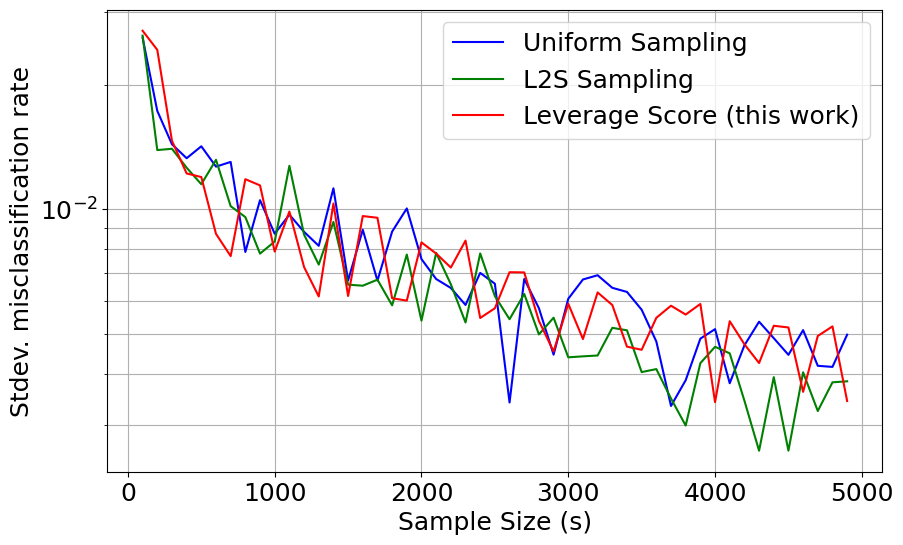

In [50]:
# Smooth the curves using a rolling average with window size
window_size =1

smoothed_std_lev_mis = np.convolve(std_lev_misclassification_rate_array, np.ones(window_size)/window_size, mode='valid')
smoothed_std_l2s_mis = np.convolve(std_l2s_misclassification_rate_array, np.ones(window_size)/window_size, mode='valid')
smoothed_std_unif_mis = np.convolve(std_unif_misclassification_rate_array, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(10, 6))



plt.plot(s_values[window_size-1:], smoothed_std_unif_mis, label="Uniform Sampling", color='b')
plt.plot(s_values[window_size-1:], smoothed_std_l2s_mis, label="L2S Sampling", color='g')
plt.plot(s_values[window_size-1:], smoothed_std_lev_mis, label="Leverage Score (this work)", color='r')


plt.xlabel("Sample Size (s)", fontsize=18)
plt.ylabel("Stdev. misclassification rate",fontsize=18)
plt.legend(fontsize=18, loc='upper right', bbox_to_anchor=(1, 1))
plt.grid(True, which='both')
plt.yscale('log')  # Set y-axis to log scale
# plt.xscale('log')

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('plots\\stdev_mis_churn.png', dpi=300)
plt.show()

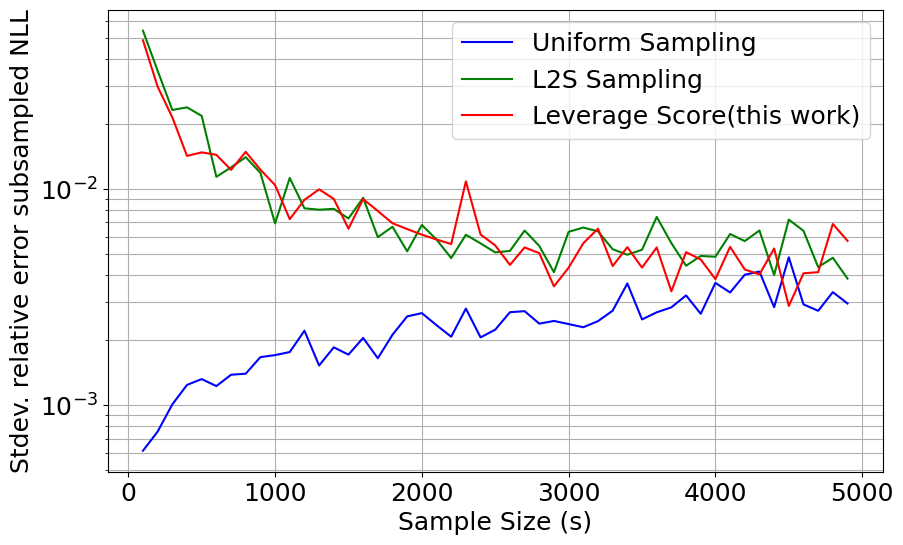

In [51]:
# Smooth the curves using a rolling average with window size 5
window_size =1

smoothed_std_lev_NLL = np.convolve(std_rel_lev_neg_log_likelihood_array, np.ones(window_size)/window_size, mode='valid')
smoothed_std_l2s_NLL = np.convolve(std_rel_l2s_neg_log_likelihood_array, np.ones(window_size)/window_size, mode='valid')
smoothed_std_unif_NLL = np.convolve(std_rel_unif_neg_log_likelihood_array, np.ones(window_size)/window_size, mode='valid')

# Plot the mean values for misclassification rates with smoothed curves
plt.figure(figsize=(10, 6))


plt.plot(s_values[window_size-1:], smoothed_std_unif_NLL, label="Uniform Sampling", color='b')
plt.plot(s_values[window_size-1:], smoothed_std_l2s_NLL, label="L2S Sampling", color='g')
plt.plot(s_values[window_size-1:], smoothed_std_lev_NLL, label="Leverage Score(this work)", color='r')

plt.xlabel("Sample Size (s)", fontsize=18)
plt.ylabel("Stdev. relative error subsampled NLL",fontsize=18)
plt.legend(fontsize=18)
plt.grid(True, which='both')
plt.legend(fontsize=18, loc='upper right', bbox_to_anchor=(1, 1))
plt.yscale('log')  # Set y-axis to log scale
# plt.xscale('log')

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('plots\\stdev_subsampled_NLL_churn.png', dpi=300)
plt.show()

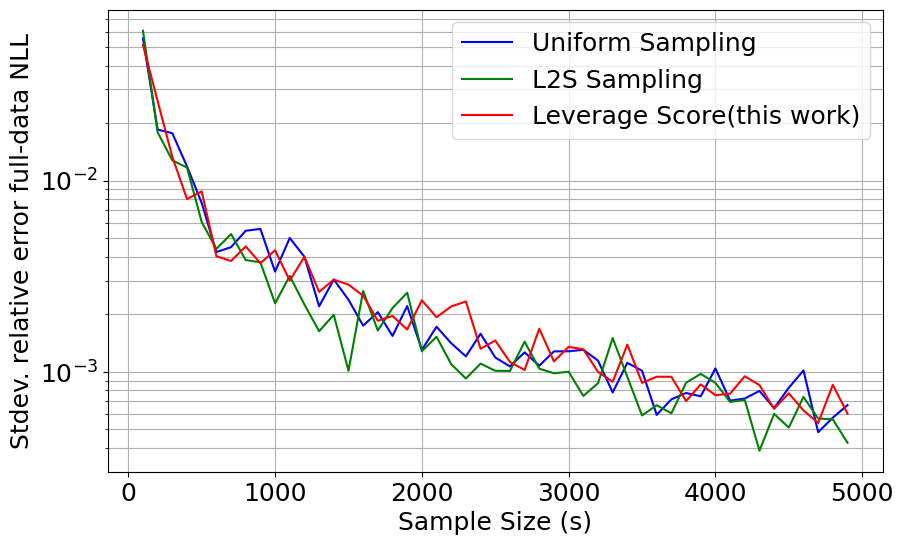

In [52]:
# Smooth the curves using a rolling average with window size 5
window_size =1

smoothed_std_lev_true_NLL = np.convolve(std_rel_lev_true_neg_log_likelihood_array, np.ones(window_size)/window_size, mode='valid')
smoothed_std_l2s_true_NLL = np.convolve(std_rel_l2s_true_neg_log_likelihood_array, np.ones(window_size)/window_size, mode='valid')
smoothed_std_unif_true_NLL = np.convolve(std_rel_unif_true_neg_log_likelihood_array, np.ones(window_size)/window_size, mode='valid')

# Plot the mean values for misclassification rates with smoothed curves
plt.figure(figsize=(10, 6))


plt.plot(s_values[window_size-1:], smoothed_std_unif_true_NLL, label="Uniform Sampling", color='b')
plt.plot(s_values[window_size-1:], smoothed_std_l2s_true_NLL, label="L2S Sampling", color='g')
plt.plot(s_values[window_size-1:], smoothed_std_lev_true_NLL, label="Leverage Score(this work)", color='r')

plt.xlabel("Sample Size (s)", fontsize=18)
plt.ylabel("Stdev. relative error full-data NLL",fontsize=18)
plt.legend(fontsize=18)
plt.grid(True, which='both')
plt.legend(fontsize=18, loc='upper right', bbox_to_anchor=(1, 1))
plt.yscale('log')  # Set y-axis to log scale
# plt.xscale('log')

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('plots\\stdev_fulldata_NLL_churn.png', dpi=300)
plt.show()